# Problem Statement


1. **What**
    Data analysis and model building activity using multi linear regression
2. **Why**
  The bike sharing company has requested us to identify the demand based on independent variables available in their data set. They also want to predict demand for newer markets 
3. **How** 
  We would use these techniques to obtain a solution for the problem statement
  1. Data cleaning
  2. Data analysis
  3. Visualizations
  4. Model training
  5. Residual analysis
  6. Prediction and evaluation



#Import statements

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import scipy as scp
import warnings
warnings.filterwarnings('ignore')

#Data processing

##load the data

In [82]:
df=pd.read_csv('day.csv',index_col='instant')
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data understanding

  From the data dictionary, understand the type of data
1. instant: record index **(May not be required, can be dropped)**
2. dteday : date **(We may be able to derive few fields, categorical)**
3. season : season (1:spring, 2:summer, 3:fall, 4:winter). **categorical**
4. yr : year (0: 2018, 1:2019) **categorical** 2018 + 2019 or 2018*2019 does not make sense. Hence treating it as categorical
5. mnth : month ( 1 to 12) **categorical**
6. holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule) **categorical**
7. weekday : day of the week **categorical**
8. workingday : if day is neither weekend nor holiday is 1, otherwise is 0. **categorical**
9. weathersit : **catagorical. Depicts the weather**
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
10.temp : temperature in Celsius **(Continuous  numerical variable)**
11.atemp: feeling temperature in Celsius **(Continuous  numerical variable)**
12.hum: humidity **(Continuous  numerical variable)**
13.windspeed: wind speed **(Continuous  numerical variable)**
14.casual: count of casual users **(Continuous  numerical)**
15.registered: count of registered users **(Continuous  numerical)**
16.cnt: count of total rental bikes including both casual and registered.(**Target variable**, Continuous  numerical)

##Data cleaning and initial processing

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


**Observation**: 

1.   There are 730 records in the dataset with 15 columns. (16 columns if we count instant field which is just serial number) 
2.   There are no fields with null value.
3.   Categorical variables are stored as numeric data type.
4.   dteday seems to be a datetime field stored incorrectly as object



### Clean and process the dteday field

In [84]:
# The field is of type object. It should be datetime as per the data dictionary.
df.dteday.nunique()
df.dteday

instant
1      01-01-2018
2      02-01-2018
3      03-01-2018
4      04-01-2018
5      05-01-2018
          ...    
726    27-12-2019
727    28-12-2019
728    29-12-2019
729    30-12-2019
730    31-12-2019
Name: dteday, Length: 730, dtype: object

In [85]:
# All the records in this field is unique. We already have fields mnth and yr representing the year and month.
# We can convert this field to datetime and derive additional fields

df.dteday=df.dteday.apply(lambda x: pd.to_datetime(x,format='%d-%m-%Y'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    int64         
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  casual      730 non-null    int64         
 13  registered  730 non-null    int64         
 14  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(10)
memory usage: 91.2 KB


In [86]:
# Create a field "dayofmonth" which can be used as independent variable. Maybe the demand is high on certain days of the month for example. We will drop the field if its of no use post analysis
df['dayofmonth'] = df.dteday.dt.day

In [87]:
# Create a field "dayofyear" which can be used as independent variable. Maybe the demand is high on certain days of the year. We will drop the field if its of no use post analysis
df['dayofyear'] = df.dteday.dt.day_of_year

In [88]:
# check if the dteday and the year, month fields match. if mismatch, we need to fix the data.
# This step actually helped me identify conversion issue which I have corrected.
# When we converted the field to datetime, pandas did not infer the day and month correctly, this showed up in the below statement. 
# fixed the issue by adding %d-%m-%Y format to pd.to_datetime()
def convert_year(yr):
  if yr == 1:
    return 2019 
  return 2018  

# add a temp field for year
df['tempyr']=df.yr.apply(convert_year)
df[(df['dteday'].dt.month != df['mnth']) | (df['dteday'].dt.year != df['tempyr'])]

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,dayofyear,tempyr
instant,,,,,,,,,,,,,,,,,,


In [89]:
#perfect, we have the date fields correct in the dataset
#drop the temp fields
df.drop('tempyr',axis=1,inplace=True)

In [90]:
#drop the dteday field. we no longer need it.
df.drop('dteday',axis=1,inplace=True)

### Clean and process the categorical fields

Categorical variables are stored as numeric fields. It may cause problems with during dummy variable creation. Convert these fields to object data type

*   season, yr , mnth , holiday, weekday , workingday , weathersit, dayofmonth and dayofyear

In [91]:
catvars=['season','yr','mnth','holiday','weekday','workingday','weathersit','dayofmonth','dayofyear']
for c in catvars:
  df[c]=df[c].astype('object')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
 14  dayofmonth  730 non-null    object 
 15  dayofyear   730 non-null    object 
dtypes: float64(4), int64(3), object(9)
memory usage: 97.0+ KB


### Check for variables with unique values less than 5

In [93]:
for c in df.columns:
  x=df[c].nunique()
  if x<= 5:
    print(f'{c}:{x}:{df[c].unique()}')

season:4:[1 2 3 4]
yr:2:[0 1]
holiday:2:[0 1]
workingday:2:[0 1]
weathersit:3:[2 1 3]


**Observation**

1.   Based on data dictionary, all of these variables are of importance for analysis and model building.




###Handle the casual and registered fields

In [94]:
# The causal and registered fields are counts and are captured under cnt field. Drop them as they are irrelavent for calculating the total demand.
df.drop(['casual','registered'],axis=1,inplace=True)

### Handle the instant field

In [95]:
# the instant field is like a serial number that can uniquely identify a record.
# It has no significance in our analysis and model building. It was loaded into data set with index_col='instant' hence, would not be considered for dataset operations
# no further action required on this field

### Handle Outliers

In [96]:
#define methods to calculate IQR and detect outliers
def iqr(x):
  return x.quantile(0.75)-x.quantile(0.25)

def iqrUpperOutlier(x):
  return x.quantile(0.75)+(1.5*iqr(x))

def iqrLowerOutlier(x):
  return x.quantile(0.25)-(1.5*iqr(x))

Identify the fields with outliers. In general, if the type is numeric, we shall check for outliers using 1.5 IQR method. Basically, any record greater than 1.5 IQR of Q3 or less than 1.5 IQR of Q1 will be dropped

In [97]:
for x in df.select_dtypes(include=['int64','float64']).columns:  
  if (df[(df[x] > iqrLowerOutlier(df[x])) & (df[x]< iqrUpperOutlier(df[x]))]).shape[0]<df.shape[0]:
    print(x)    

hum
windspeed


fields hum and windspeed have few outliers. Lets investigate them further.

<AxesSubplot:>

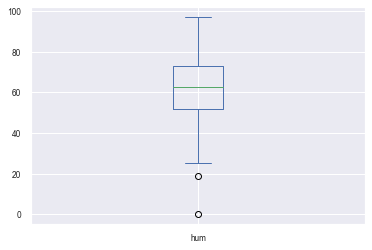

In [98]:
df.hum.plot.box()

Outliers seen in the box plot, drop them as they are couple of records.

In [99]:
df=df[(df.hum > iqrLowerOutlier(df.hum)) & (df.hum< iqrUpperOutlier(df.hum))]

<AxesSubplot:>

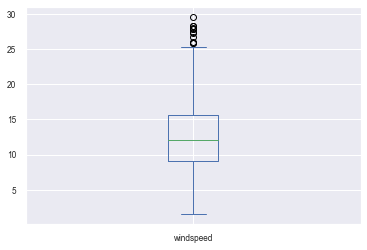

In [100]:
df.windspeed.plot.box()

Outliers seen in the box plot, drop those records

In [101]:
df=df[(df.windspeed > iqrLowerOutlier(df.windspeed)) & (df.windspeed< iqrUpperOutlier(df.windspeed))]
df.shape

(716, 14)

#Data visualization, analysis

In [102]:
# catvars has the categorical variables. define a series for numeric variables.
numvars=df.select_dtypes(include=['int64','float64']).columns

In [103]:
numvars

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [104]:
# check for correlation
df.corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991732,0.115823,-0.140355,0.625421
atemp,0.991732,1.000000,0.128144,-0.166220,0.628802
hum,0.115823,0.128144,1.000000,-0.204546,-0.134521
windspeed,-0.140355,-0.166220,-0.204546,1.000000,-0.216685
cnt,0.625421,0.628802,-0.134521,-0.216685,1.000000


<AxesSubplot:>

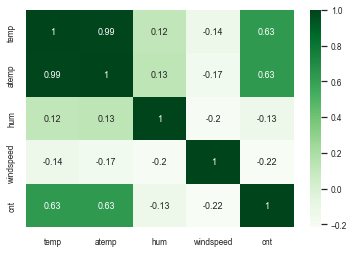

In [105]:
# plot a heatmap
sns.heatmap(data=df.corr(),cmap='Greens',annot=True)

**Observation**

1.   temp and atemp are highly positive correlated (0.99)
2.   atemp and temp are positively correlated to cnt (0.63)


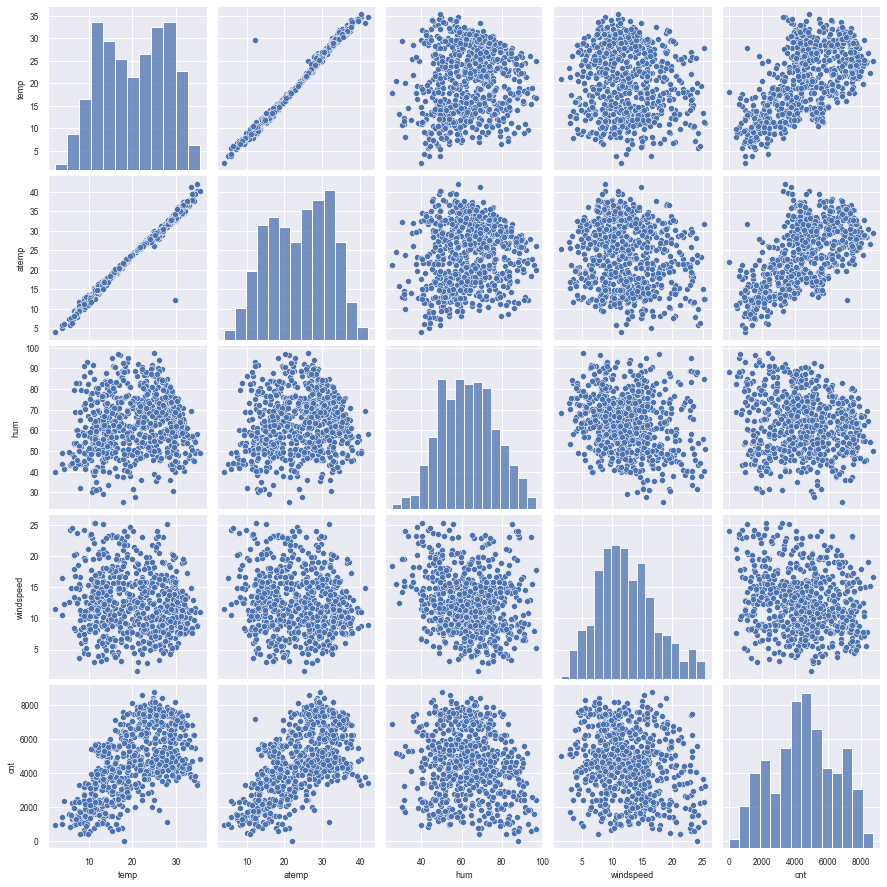

In [106]:
# draw a pair plot for the numeric variables to see if its a good candidate for linear regression
sns.pairplot(data=df,vars=numvars)
plt.show()

**Observation**


1.   Temp and atemp have a linear relationship.
2.   temp, atemp have a linear relationship with target variable cnt
3.   The data looks good for linear regression modeling as we have independent variables that have linear relationship with target variable.



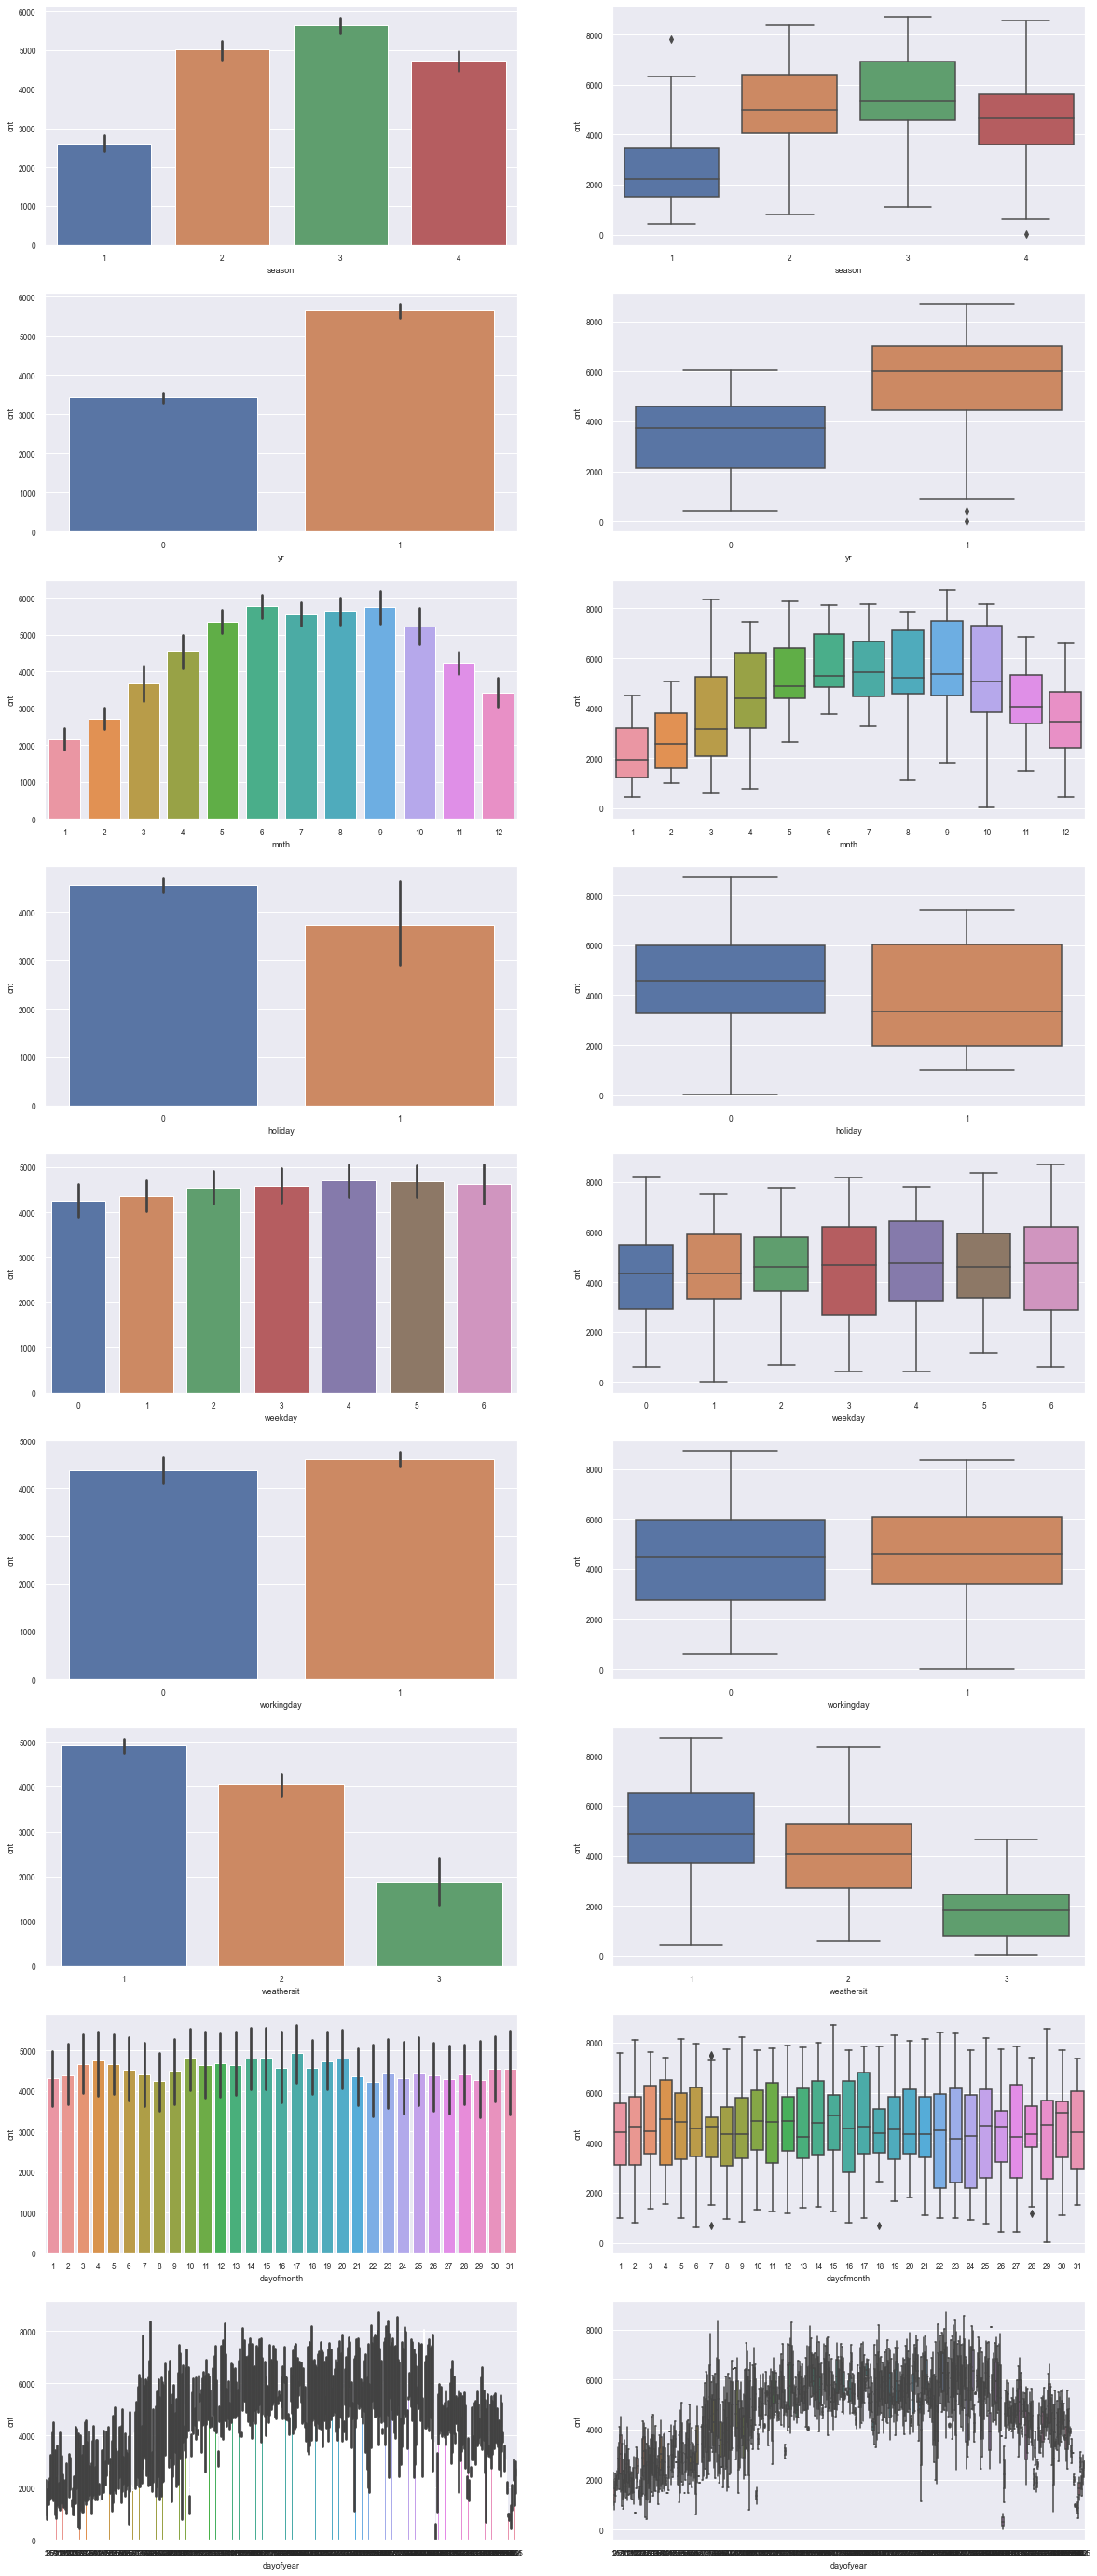

In [107]:
# analysis of categorical variables, draw subplots, Data seems to be already binned and may not require further binning.
plt.figure(figsize=(20, 50))
ix=1
for c in catvars:
  plt.subplot(9,2,ix)
  sns.barplot(x=c,y='cnt',data=df)
  ix=ix+1  
  plt.subplot(9,2,ix)  
  sns.boxplot(x=c,y='cnt',data=df)
  ix=ix+1
plt.show()

**Observations**


1.   Demand was least in the spring season
2.   Demand was the highest in the fall season with median at around 5000
3.   Demand in 2019 was higher than 2018. The median was around 6000 which was also the upper whisker of the box plot of 2018.
4.   Demand in 2018 was approximately equal to quartile 1 (25%) of 2019 demand as per data points in dataset
5.   Month 5 to 10 had good demand and co-relates with season trend observed. Median during these months were near 5000
6.   Demand was low during holidays. Median of demand on holidays was equal to quartile 1 (25%) of demand on non holidays as per data points in dataset
7.   2nd day of the week had Q1 higher than rest of the days. Medians seem to be almost the same throughout the week
8.  There is slightly higher demand on working days.
9.  Demand was high when the weather was clear with few clouds or partly cloudy
10. Demand was the least with weathersit 3, i.e light rain or snow.
11. Demand was nil when weather was thunderstorm, heavy rain
12. No clear trend seen in day of the month variable, except for dip on 22nd. 
13. Day of the year, seems to indicate and confirm the general trend observed that demand was high in the months 5 to 10.



In [108]:
# as there is no clear trend seen from day of the month and it can be explained by day of the week to certain extent, drop it
df.drop('dayofmonth',axis=1,inplace=True)
catvars.remove('dayofmonth')
# as there is no clear trend seen from day of the year and it can be explained by other variables such as day of week and mnth, drop it
df.drop('dayofyear',axis=1,inplace=True)
catvars.remove('dayofyear')

#Data preperation for modeling

## Dummy variables

In [109]:
catvars

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [110]:
#create dummy variables for categorical variables. Drop first ensures we have m-1 fields.
dv=pd.get_dummies(data=df[catvars],drop_first=True)
dv.head()

,season_2,season_3,season_4,yr_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [111]:
#drop the actual catvars and replace with dummy vars
df.drop(catvars,axis=1,inplace=True)
df=pd.concat([df,dv],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716 entries, 1 to 730
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          716 non-null    float64
 1   atemp         716 non-null    float64
 2   hum           716 non-null    float64
 3   windspeed     716 non-null    float64
 4   cnt           716 non-null    int64  
 5   season_2      716 non-null    uint8  
 6   season_3      716 non-null    uint8  
 7   season_4      716 non-null    uint8  
 8   yr_1          716 non-null    uint8  
 9   mnth_2        716 non-null    uint8  
 10  mnth_3        716 non-null    uint8  
 11  mnth_4        716 non-null    uint8  
 12  mnth_5        716 non-null    uint8  
 13  mnth_6        716 non-null    uint8  
 14  mnth_7        716 non-null    uint8  
 15  mnth_8        716 non-null    uint8  
 16  mnth_9        716 non-null    uint8  
 17  mnth_10       716 non-null    uint8  
 18  mnth_11       716 non-null    

## Split training and test data

In [112]:
df_train,df_test=train_test_split(df,train_size=0.7,random_state=100)
print(df_train.shape) # training data
print(df_test.shape)  # test data

(501, 30)
(215, 30)


##Rescaling

In [113]:
df.describe()

,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,mnth_2,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,...,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,20.400717,23.821520,63.132034,12.481868,4536.613128,0.252793,0.262570,0.245810,0.498603,0.072626,...,0.029330,0.142458,0.143855,0.142458,0.141061,0.143855,0.142458,0.684358,0.339385,0.027933
std,7.529887,8.159941,13.916864,4.812977,1932.256146,0.434917,0.440338,0.430867,0.500348,0.259703,...,0.168847,0.349764,0.351188,0.349764,0.348328,0.351188,0.349764,0.465096,0.473832,0.164896
min,2.424346,3.953480,25.416700,1.500244,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.828962,16.894537,52.458300,8.989859,3214.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.739153,24.605200,63.083300,11.958797,4572.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,26.931885,30.556050,73.260425,15.458374,6031.750000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,35.328347,42.044800,97.250000,25.333236,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The values for temp, hum and windspeed and cnt(target variable) look at different scales compared to each other. Temp and atemp look to be on approximately similar scales/unit. 

Use min max scaling to compress data between 0 and 1

In [114]:
numvars

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [115]:
scaler = MinMaxScaler()
# fit on the data
df_train[numvars] = scaler.fit_transform(df_train[numvars]) #fit learns the min and max, transform rescales the data. fit_transform combines the two
df_train

,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,mnth_2,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
729,0.252441,0.204242,0.293114,0.923102,0.204096,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
542,0.733702,0.689995,0.126342,0.914353,0.853659,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
117,0.719799,0.663818,0.826912,0.814718,0.442936,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
719,0.347624,0.342763,0.572964,0.309436,0.472388,0,0,1,1,0,...,0,0,0,0,1,0,0,1,1,0
497,0.648145,0.623239,0.288693,0.283207,0.852163,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.856692,0.799824,0.601391,0.412594,0.777957,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
56,0.391705,0.363162,0.640062,0.911252,0.165555,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
357,0.403236,0.399361,0.600758,0.708020,0.251611,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


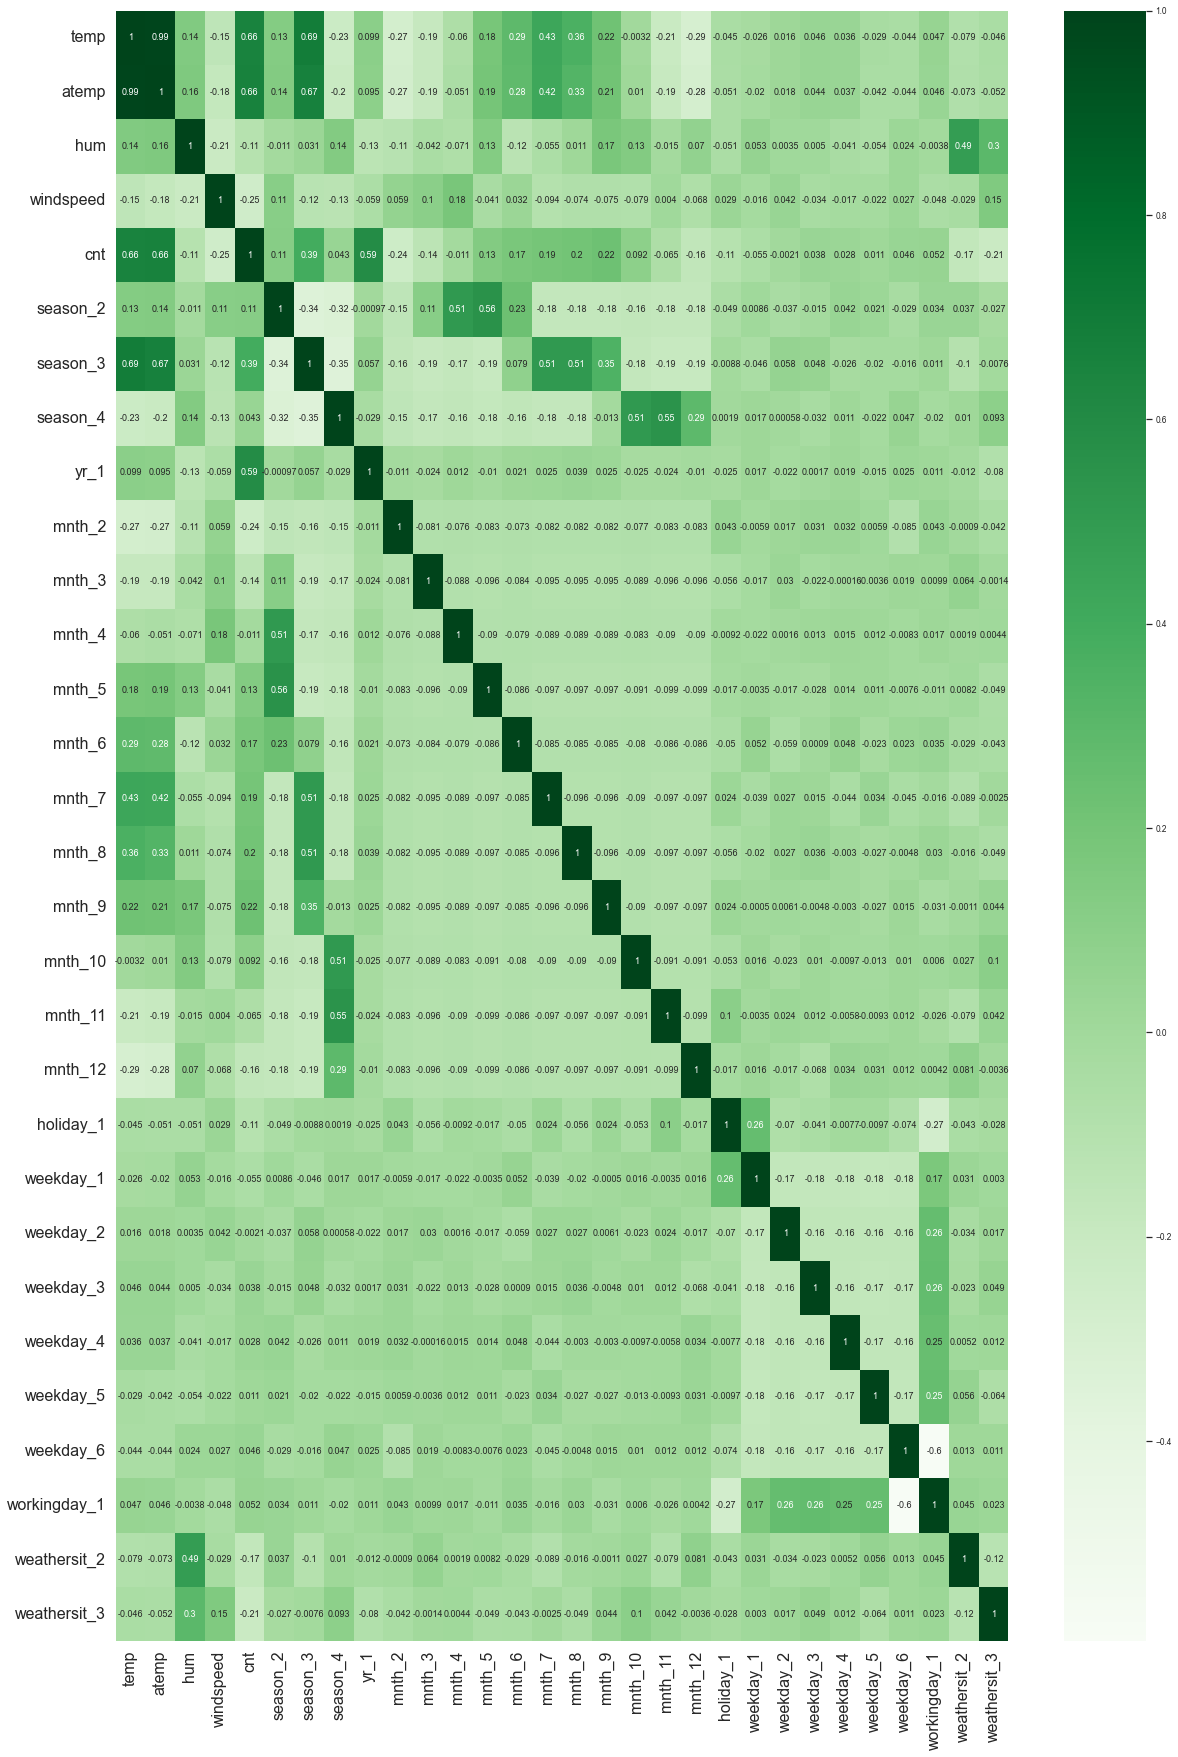

In [116]:
# check the correlation between variables after rescaling
plt.figure(figsize=(20,30))
plt.xticks(rotation=90,fontsize = 16)
plt.yticks(rotation=90,fontsize = 16)
sns.set(font_scale=0.75)
sns.heatmap(df_train.corr(),cmap='Greens',annot=True)
plt.show()

**Observation**
1. There is positive correlation between temp, atemp and target variable cnt (0.65)
2. There is positive correlation between yr_1 (2019) and target variable cnt (0.59)
3. There is a positive correlation between season_3 (fall) and target variable cnt(0.37)
4. positive correlation observed between seasons and mnths , seasons and temp
5. positive correlation observed between season_4 and target variable cnt (0.026)
6. negative correlation observed between hum and target variable cnt (-0.059)
7. negative correlation observed between windspeed and target variable cnt(-0.25)


#Modeling

In [117]:
#create the X and y train dataframe from df_train

In [118]:
y_train = df_train.pop('cnt')
X_train = df_train

statsmodels library provides detailed stastical information which can be used for feature selection.
We can perform feature selection in multiple ways.
1. We start the feature selection by looking at the correlation matrix. Variables are chosen in the descending order of the correlation 1 --> 0 --> -1. Instead of elimination, we can increase variables one at a time. 
2. Include all the features and use p and VIF values to determine which feature to eliminate.
3. Use RFE and manual judgement to select features.

Lets look at all of the options in this study. We will train multiple models with each method in the next sections.

## Feature selection and Model building using statsmodels by correlation

In [119]:
def calculate_and_print_VIF(df):
  vif = pd.DataFrame()
  vif['Features']=df.columns
  vif['VIF']=[variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
  vif['VIF']=round(vif['VIF'],2)
  vif=vif.sort_values(by='VIF',ascending=False)
  return vif

def model_using_statsmodel(cols):
  # add the constant
  X_train_sm=sm.add_constant(X_train[cols])
  #create first model
  lr=sm.OLS(y_train,X_train_sm)
  #fit
  lr_model=lr.fit()
  #print report
  print(lr_model.params)
  print(lr_model.summary())
  if(len(cols)>1):
    dvif = calculate_and_print_VIF(X_train_sm[cols])
    print(dvif.head(50))
  return X_train_sm, lr_model

cols=['atemp']
X_train_sm= model_using_statsmodel(cols)  

const    0.162400
atemp    0.681238
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     379.9
Date:                Wed, 14 Sep 2022   Prob (F-statistic):           2.46e-63
Time:                        21:59:14   Log-Likelihood:                 175.96
No. Observations:                 501   AIC:                            -347.9
Df Residuals:                     499   BIC:                            -339.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

Significance of few metrics presented in the above summary that we plan to use.

*   **Coefficients**: Describe the mathematical relationship between each independent variable and dependent variable.
*   **P-Value** : It helps determine if the relationship observed in the sample also exists in the larger population. It basically tests for null hypothesis that the independent variable has no correlation with the dependent variable.
*   **VIF**: variance inflation factor, It quantifies the extent of correlation between one predictor and the other predictors in the model. It is a measure of the amount of multicollinearity
*   **R-Squared** : The coefficient of determination is the proportion of the variation in the dependent variable that is predictable from the independent variable(s).
*   **Adjusted-R-Squared** : Adjusted R-squared is a version of R-squared that varies based on the number of predictors in the model. It punishes for inclusion of a predictor which does not improve the model more that that by chance. It is always equal or less than R-squared.



**Analysis**
1. R-squared is 0.432
2. Adjusted-R-squared does not make much sense as only 1 variable is selected at this point in the model.
3. Co-efficients of 0.6812 suggest a positive relation between target and independent variable. 
4. P value is 0. Consider the significance level (Alpha) to be 5% (0.05). If the p value is less than alpha, it means, we can reject the null hypothesis which states that there is zero correlation between independent and dependent variable at population level using sample data. i.e it is stastically significant variable.
 **Keep this variable**


In [120]:
# add temp
cols=['atemp','temp']
X_train_sm = model_using_statsmodel(cols)  

const    0.163644
atemp    0.400936
temp     0.262165
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     190.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):           3.08e-62
Time:                        21:59:14   Log-Likelihood:                 176.63
No. Observations:                 501   AIC:                            -347.3
Df Residuals:                     498   BIC:                            -334.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

1. R-squared barely improved.
2. Adjusted R-squared did not reduce.
3. Coefficient of atemp variable decreased and that of temp is lower than atemp.
4. p value is > 0.05 for temp variable. This means, it is stastically insignificant. 
5. VIF is high >5 after we introduced temp. It describes the extent of correlation between the temp and atemp variables (Multicollinearity). i.e temp is explained by other independent variables(atemp) in the model **drop this variable**


In [121]:
cols=['atemp','yr_1']
X_train_sm = model_using_statsmodel(cols)  

const    0.067768
atemp    0.628372
yr_1     0.242281
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     630.5
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.45e-137
Time:                        21:59:14   Log-Likelihood:                 350.25
No. Observations:                 501   AIC:                            -694.5
Df Residuals:                     498   BIC:                            -681.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

1. R-squared improved. It is 0.717
2. Adjusted R-squared is close to R-squared. This metric punishes for inclusion of predictors which do not improve the model any more than that by chance.
3. Coefficient is positively correlated for yr_1 with taraget variable
4. p value is 0 for yr_1 which means its statistically significant 
5. VIF is low < 5. It means, the yr_1 variable may not be completely explained by other predictors in the model. **Keep this variable**


In [122]:
cols=['atemp','yr_1','season_3']
X_train_sm= model_using_statsmodel(cols)  

const       0.050041
atemp       0.683354
yr_1        0.242039
season_3   -0.040437
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     426.9
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          4.39e-137
Time:                        21:59:14   Log-Likelihood:                 353.39
No. Observations:                 501   AIC:                            -698.8
Df Residuals:                     497   BIC:                            -681.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

1. R-squared is 0.720
2. Adjusted R-squared is near R-squared. This signifies that the predictors in the model add value to improve the model.
2. Coefficient of season_3 is negatively correlated with target variable
3. p value is 0.013 for season_3 which means its statistically significant 
4. VIF is low < 5. **Keep this variable**


In [123]:
cols=['atemp','yr_1','season_3','season_4']
X_train_sm= model_using_statsmodel(cols)  

const       0.020833
atemp       0.673050
yr_1        0.243074
season_3   -0.003944
season_4    0.098495
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     374.5
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.62e-148
Time:                        21:59:14   Log-Likelihood:                 382.67
No. Observations:                 501   AIC:                            -755.3
Df Residuals:                     496   BIC:                            -734.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

1. R-squared is 0.751
2. Adjusted R-squared is 0.749. This signifies that the predictors in the model add value to improve the model.
3. Coefficient of season_4 is positively correlated with target variable
4. p value is 0 but p value for season_3 increased beyond significance level. Which means with introduction of season_4, season_3 becomes statistically insignificant.
4. VIF is low < 5. **Keep this variable**
5. **Drop season_3 due to high p value and higer VIF compared to season_4.**

In [124]:
cols=['atemp','yr_1','season_4','windspeed']
X_train_sm= model_using_statsmodel(cols)  

const        0.076743
atemp        0.649770
yr_1         0.241433
season_4     0.091931
windspeed   -0.091645
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     388.0
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.52e-151
Time:                        21:59:14   Log-Likelihood:                 389.36
No. Observations:                 501   AIC:                            -768.7
Df Residuals:                     496   BIC:                            -747.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

1. R-squared is 0.758
2. Adjusted R-squared is 0.756. This signifies that the predictors in the model add value to improve the model.
3. Coefficient of windspeed is negatively correlated with target variable 
4. p value is 0 windspeed is stastically significant
5. VIF is low < 5. **Keep this variable**

In [125]:
cols=['atemp','yr_1','season_4','windspeed','mnth_8']
X_train_sm= model_using_statsmodel(cols)  

const        0.076757
atemp        0.649701
yr_1         0.241433
season_4     0.091946
windspeed   -0.091636
mnth_8       0.000178
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     309.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          7.38e-150
Time:                        21:59:14   Log-Likelihood:                 389.36
No. Observations:                 501   AIC:                            -766.7
Df Residuals:                     495   BIC:                            -741.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

1. R-Squared did not improve after addition of mnth_8 variable
2. Co-efficients value suggests mnth_8 variable is not correlated with target variable.
3. p value > 0.05 so mnth_8 is statistically insignificant.
4. **drop this variable**

In [126]:
# testing each variable using this method of feature selection is tedious manual efort, we shall use other techniques in next section. 
#Final model using the first technique has a R-squared of 0.758, adjusted R-squared of 0.756
cols=['atemp','yr_1','season_4','windspeed']
X_train_sm, lr_model = model_using_statsmodel(cols)  

const        0.076743
atemp        0.649770
yr_1         0.241433
season_4     0.091931
windspeed   -0.091645
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     388.0
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.52e-151
Time:                        21:59:14   Log-Likelihood:                 389.36
No. Observations:                 501   AIC:                            -768.7
Df Residuals:                     496   BIC:                            -747.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

### Residual analysis

Calculate the error terms and plot the distribution. Use the training set to predict the y-set (ypred), calculate the residual (actual-predicted). The distribution should be normally distributed and mean centered around 0

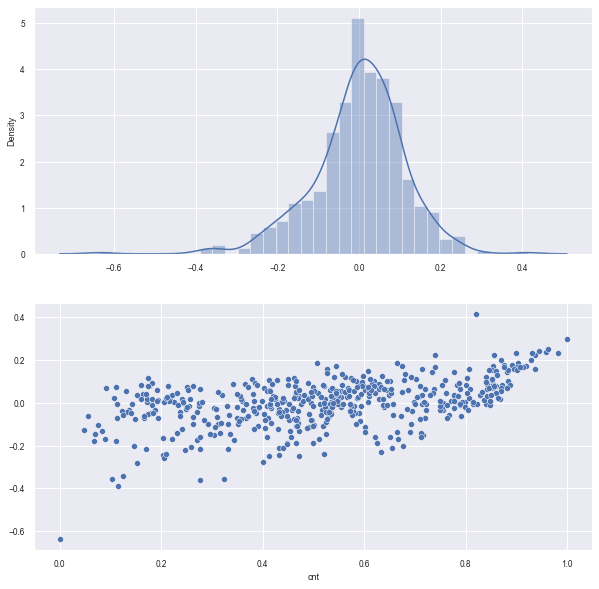

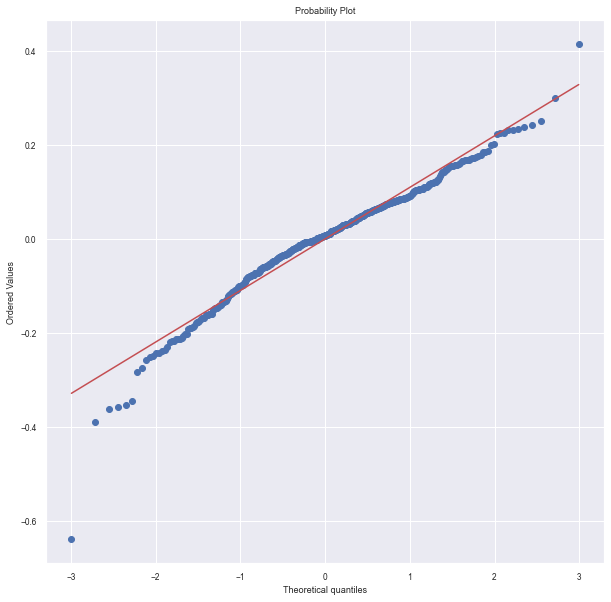

In [127]:
def plot_error(X, lr_model,y):
  y_pred = lr_model.predict(X)
  res=y-y_pred
  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  sns.distplot(res)
  plt.subplot(2,1,2)
  sns.scatterplot(y,res)  
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))
  _, (__, ___, r) = scp.stats.probplot(res, plot=ax, fit=True)

plot_error(X_train_sm,lr_model,y_train)

**Observation**: Error terms are distributed normally and mean is at 0
*  Homoscedasticity: No patterns seen for the target variable vs residual scatterplot..
*  The Q-Q plot shows the residual distribution is fairly near or on the 45 degree line. Data in the residual distribution may be slightly peaked in the middle.


### Prediction

In [128]:
#predictions on test set
# we should not fit the test data set, the scaler instance same as that used for training set. There it has fit and learnt the min and max.
df_test[numvars]=scaler.transform(df_test[numvars])
df_test.head()

,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,mnth_2,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
584,0.868455,0.827713,0.627290,0.265707,0.834215,0,1,0,1,0,...,0,0,1,0,0,0,0,1,1,0
494,0.662048,0.634223,0.688567,0.545436,0.540152,1,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
295,0.466335,0.463565,0.514214,0.197559,0.493097,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
158,0.832094,0.771951,0.466836,0.465023,0.553497,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
671,0.379708,0.370630,0.351863,0.685331,0.670156,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0


In [129]:
y_test=df_test.pop('cnt')
X_test=df_test

In [130]:
#make prediction on the test set (y_test_pred)
# add a const/intercept to the test set
X_test_sm = sm.add_constant(X_test[cols])
y_test_pred=lr_model.predict(X_test_sm)

In [131]:
# evaluate the model, calculate r-score, on the test data set
r2=r2_score(y_true=y_test,y_pred=y_test_pred)
r2

0.6618207420016119

In [132]:
adj_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adj_r2)

0.6088


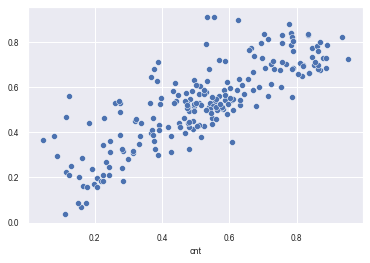

In [133]:
sns.scatterplot(y_test,y_test_pred)
plt.show()

Observation : Linear relationship observed between y_test and predicted test values

In [134]:
def generate_model_equation(lr_model):
  summary = pd.read_html(lr_model.summary().tables[1].as_html(),header=0)[0]
  summary.columns=['predictors','coef', 'std err', 't', 'P>|t|', '0.025', '0.975']  
  eq= 'Model equation = '
  for i, x in summary.iterrows():   
    if x['predictors'] == 'const':
      eq=eq+' '+ str(x['coef'])
    elif x[1] > 0:
      eq=eq+' +('+str(x['coef'])+') * '+x['predictors']
    else:
      eq=eq+' -('+str(-1 * x['coef'])+') * '+x['predictors']
  print(eq)

1. R-squared for training set is 0.758 and adjusted R-squared is 0.756
2. R-squaraed for test set is 0.6618 and adjusted R-squared is 0.6088
3. Difference between rscores or train and test data is below 5%. This means the model is **not** overfit.
4. **The model looks good.**

**Model Equation**

In [135]:
generate_model_equation(lr_model)

Model equation =  0.0767 +(0.6498) * atemp +(0.2414) * yr_1 +(0.0919) * season_4 -(0.0916) * windspeed


###Summarizing the model
1. A unit increase in temperature affects the demand by 0.6498 units
2. A unit increase in yr_1 affects the demand by 0.2414 units
3. A unit increase in windspeed affects the demand negatively by 0.0916 units
4. A unit increase in season_4 affects the demand by 0.0919

temperature, year and windspeed and season are the important predictors for demand. From instinct, this would also make sense.

##Feature selection and Model building using statsmodel and by elimination

In [136]:
# X_train, y_train, X_test, y_test
# start with all the fields
cols=['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4',
       'yr_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'holiday_1',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']
X_train_sm= model_using_statsmodel(cols)

const           0.136913
temp            0.315616
atemp           0.131543
hum            -0.132081
windspeed      -0.117017
season_2        0.081449
season_3        0.072917
season_4        0.182501
yr_1            0.229567
mnth_2          0.035222
mnth_3          0.080171
mnth_4          0.068031
mnth_5          0.097560
mnth_6          0.063515
mnth_7          0.034149
mnth_8          0.066032
mnth_9          0.135303
mnth_10         0.050723
mnth_11        -0.018437
mnth_12         0.002906
holiday_1      -0.032584
weekday_1      -0.016608
weekday_2      -0.001482
weekday_3       0.011454
weekday_4      -0.009442
weekday_5       0.017394
weekday_6       0.060239
workingday_1    0.033900
weathersit_2   -0.043561
weathersit_3   -0.200549
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.85

1. R-squared is 0.862
2. Adjusted R-squared is 0.853. Its significantly less. It signifies there are variables that do not add expected value to the model.
3. VIF for few of the features is infinity. Lets drop them one by one until we do not have any infinite VIF variables.
4. Dropping mnth_12 as its p value is high (0.905)(Stastically insignificant)


In [137]:
cols=['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4',
       'yr_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'holiday_1',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']
X_train_sm= model_using_statsmodel(cols)

const           0.137525
temp            0.316087
atemp           0.131761
hum            -0.131856
windspeed      -0.116997
season_2        0.081959
season_3        0.074018
season_4        0.184291
yr_1            0.229564
mnth_2          0.034337
mnth_3          0.079016
mnth_4          0.066501
mnth_5          0.095869
mnth_6          0.061557
mnth_7          0.031773
mnth_8          0.063693
mnth_9          0.132856
mnth_10         0.047859
mnth_11        -0.021178
holiday_1      -0.032636
weekday_1      -0.016621
weekday_2      -0.001553
weekday_3       0.011394
weekday_4      -0.009411
weekday_5       0.017434
weekday_6       0.060155
workingday_1    0.033880
weathersit_2   -0.043594
weathersit_3   -0.200665
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.854
Method:                

1. R-squared is 0.862
2. Adjusted R-squared is 0.854. Its significantly less. It signifies there are variables that do not add expected value to the model.
3. VIF for few of the features is infinity. Lets drop them one by one until we do not have any infinite VIF variables.
4. Dropping weekday_2 as its p value is high (0.888) (Stastically insignificant)


In [138]:
cols=['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4',
       'yr_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'holiday_1',
       'weekday_1', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']
X_train_sm= model_using_statsmodel(cols)

const           0.137525
temp            0.316087
atemp           0.131761
hum            -0.131856
windspeed      -0.116997
season_2        0.081959
season_3        0.074018
season_4        0.184291
yr_1            0.229564
mnth_2          0.034337
mnth_3          0.079016
mnth_4          0.066501
mnth_5          0.095869
mnth_6          0.061557
mnth_7          0.031773
mnth_8          0.063693
mnth_9          0.132856
mnth_10         0.047859
mnth_11        -0.021178
holiday_1      -0.034188
weekday_1      -0.015068
weekday_3       0.012947
weekday_4      -0.007858
weekday_5       0.018987
weekday_6       0.060155
workingday_1    0.032327
weathersit_2   -0.043594
weathersit_3   -0.200665
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statis

1. R-squared is 0.861
2. Adjusted R-squared is 0.853
2. mnth_7 has a high p-value 0.406. The variable is statistically insignificant
4. Drop the mnth_7 field.

Repeating the process until VIF below 5 is reached. The strategy will be to drop variables in this order
1. high p-value(>0.05) and high VIF(>5) --drop
2. high p-value, low VIF --drop
3. low p and high VIF -- drop
4. low p and low VIF --keep

Skipped few repetitive steps for improving readablitity of the code. The final list of fields is as below

In [139]:
cols=[ 'windspeed', 'season_2', 'season_3', 'season_4','yr_1', 'mnth_3', 
        'mnth_9', 'mnth_10', 'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']
X_train_sm, lr_model = model_using_statsmodel(cols)

const           0.222665
windspeed      -0.119784
season_2        0.267416
season_3        0.323588
season_4        0.205136
yr_1            0.245213
mnth_3          0.039136
mnth_9          0.080697
mnth_10         0.110685
weekday_6       0.065921
workingday_1    0.047949
weathersit_2   -0.076773
weathersit_3   -0.311852
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     147.1
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.83e-153
Time:                        21:59:16   Log-Likelihood:                 417.32
No. Observations:                 501   AIC:                            -808.6
Df Residuals:                     488   BIC:                            -753.8
Df Model:                   

1. R-squared is 0.783 and adjusted R-squared is 0.778. The predictors in the model add value to improve it.

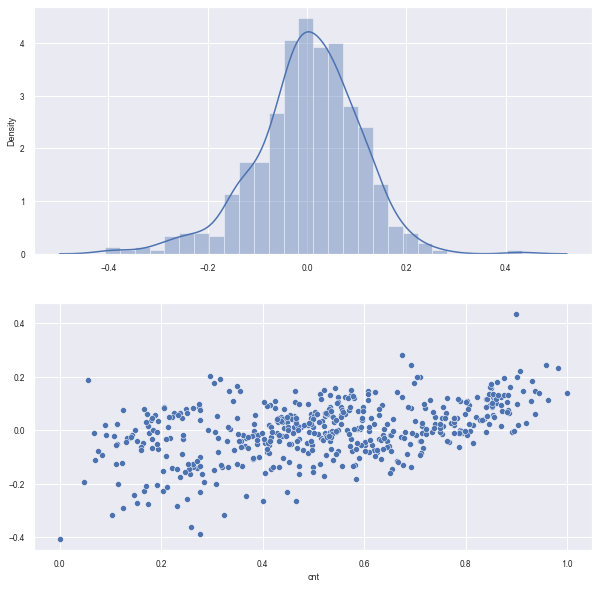

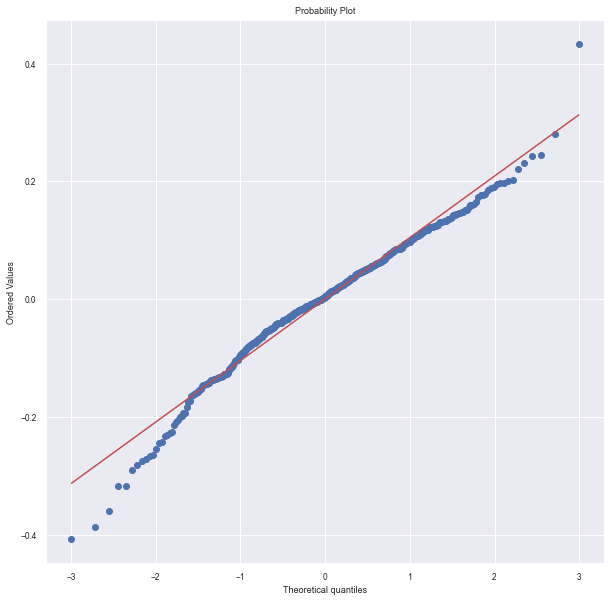

In [140]:
plot_error(X_train_sm,lr_model,y_train)

**Observation**: Error terms are distributed normally and mean is at 0
*  Homoscedasticity: No patterns seen for the target variable vs residual scatterplot.
*  The Q-Q plot shows the residual distribution is fairly near or on the 45 degree line. residual is normally distributed.



### Prediction

In [141]:
#make prediction on the test set (y_test_pred)
# add a const/intercept to the test set
X_test_sm = sm.add_constant(X_test[cols])
y_test_pred=lr_model.predict(X_test_sm)

In [142]:
# evaluate the model, r-squared, on the test
# r-squared
r2=r2_score(y_true=y_test,y_pred=y_test_pred)
r2

0.7692401858230162

In [143]:
adj_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adj_r2)

0.7331


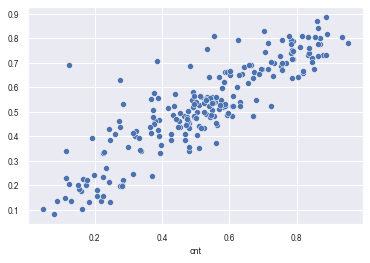

In [144]:
sns.scatterplot(y_test,y_test_pred)
plt.show()

Observation : Linear relationship observed between y_test and predicted test values

1. R-squared for training set is 0.783
2. Adjusted R-squared for train is 0.778
3. R-squared for test set is 0.769
4. Adjusted R-squared for test set is 0.733
3. Prediction seems to be accurate. No overfit observed
4. **The model looks good**

**Model equation**

In [145]:
generate_model_equation(lr_model)

Model equation =  0.2227 -(0.1198) * windspeed +(0.2674) * season_2 +(0.3236) * season_3 +(0.2051) * season_4 +(0.2452) * yr_1 +(0.0391) * mnth_3 +(0.0807) * mnth_9 +(0.1107) * mnth_10 +(0.0659) * weekday_6 +(0.0479) * workingday_1 -(0.0768) * weathersit_2 -(0.3119) * weathersit_3


###Summarizing the model
From model equation, weather situation , windspeed, season are the important predictors for demand. This makes sense instintively.


## Feature selection and Model building using RFE and manual judgement

In [146]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,n_features_to_select=10)

In [147]:
print(lm.coef_)

[ 0.31561593  0.13154281 -0.13208109 -0.11701689  0.08144928  0.0729174
  0.18250085  0.22956746  0.03522155  0.08017148  0.0680307   0.09755989
  0.06351544  0.03414867  0.06603217  0.13530327  0.05072313 -0.01843655
  0.00290589 -0.03258388 -0.01660816 -0.00148206  0.0114544  -0.00944158
  0.0173936   0.06023942  0.03390009 -0.04356136 -0.20054914]


In [148]:
print(lm.intercept_)

0.13691297085981236


In [149]:
rfe=rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', False, 2),
 ('season_4', True, 1),
 ('yr_1', True, 1),
 ('mnth_2', False, 11),
 ('mnth_3', False, 5),
 ('mnth_4', False, 7),
 ('mnth_5', False, 6),
 ('mnth_6', False, 8),
 ('mnth_7', False, 12),
 ('mnth_8', False, 9),
 ('mnth_9', True, 1),
 ('mnth_10', False, 3),
 ('mnth_11', False, 15),
 ('mnth_12', False, 19),
 ('holiday_1', True, 1),
 ('weekday_1', False, 17),
 ('weekday_2', False, 20),
 ('weekday_3', False, 16),
 ('weekday_4', False, 18),
 ('weekday_5', False, 14),
 ('weekday_6', False, 10),
 ('workingday_1', False, 13),
 ('weathersit_2', False, 4),
 ('weathersit_3', True, 1)]

In [150]:
cols=X_train.columns[rfe.support_]
cols

Index(['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_4', 'yr_1',
       'mnth_9', 'holiday_1', 'weathersit_3'],
      dtype='object')

In [151]:
#lets proceed with using stats model to check the stats of the model and elimination if required
X_train_sm, lr_model= model_using_statsmodel(cols)

const           0.186325
temp            0.553226
atemp           0.043440
hum            -0.201365
windspeed      -0.134566
season_2        0.079594
season_4        0.139106
yr_1            0.223773
mnth_9          0.109708
holiday_1      -0.089760
weathersit_3   -0.145681
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     254.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          5.69e-187
Time:                        21:59:17   Log-Likelihood:                 491.19
No. Observations:                 501   AIC:                            -960.4
Df Residuals:                     490   BIC:                            -914.0
Df Model:                          10                                         

1. R-squared is 0.839 and adjusted R-Squared is 0.835
2. p value for atemp is high at 0.752. This means the variable is stastically insignificant.
3. The VIF of atemp is high > 5
**4. Drop the field.**


In [152]:
cols = cols.drop('atemp')
X_train_sm, lr_model= model_using_statsmodel(cols)

const           0.187238
temp            0.592841
hum            -0.200858
windspeed      -0.135882
season_2        0.080060
season_4        0.139568
yr_1            0.223724
mnth_9          0.109770
holiday_1      -0.090012
weathersit_3   -0.146110
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     283.6
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.45e-188
Time:                        21:59:17   Log-Likelihood:                 491.14
No. Observations:                 501   AIC:                            -962.3
Df Residuals:                     491   BIC:                            -920.1
Df Model:                           9                                         
Covariance Type:        

1. R-squared is 0.839 and adjusted R-squared is 0.836
2. VIF is high for the field hum. Drop it.

In [153]:
cols = cols.drop('hum')

In [154]:
X_train_sm, lr_model= model_using_statsmodel(cols)

const           0.076594
temp            0.570445
windspeed      -0.089875
season_2        0.073315
season_4        0.127205
yr_1            0.235139
mnth_9          0.090137
holiday_1      -0.081993
weathersit_3   -0.231638
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     264.5
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          8.51e-173
Time:                        21:59:17   Log-Likelihood:                 451.98
No. Observations:                 501   AIC:                            -886.0
Df Residuals:                     492   BIC:                            -848.0
Df Model:                           8                                         
Covariance Type:            nonrobust            

1. R-squared looks good at 0.811 and adjusted R-squared at 0.808. All predictors are improving the model.
2. p values for the model looks good < 0.05. All variables are statistically significant.
3. VIF is below 5. Predictors are not strongly correlated to each other
4. The model overall looks good.

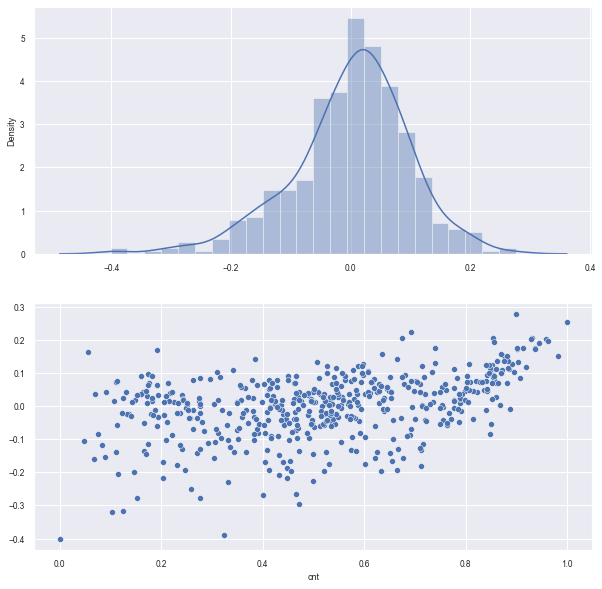

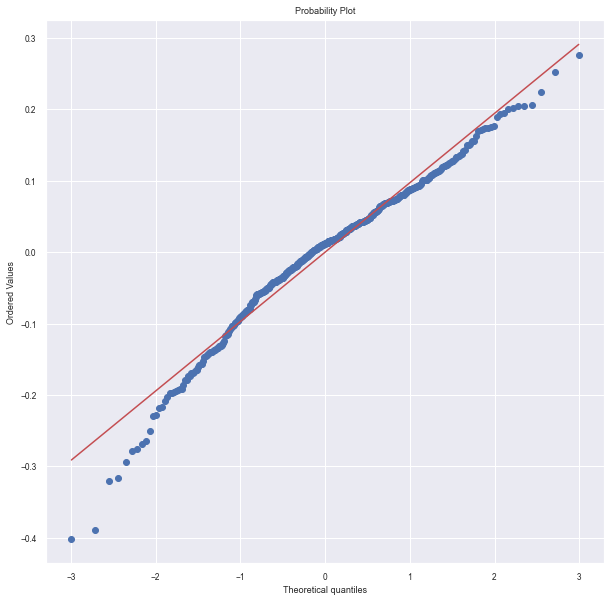

In [155]:
res = plot_error(X_train_sm,lr_model,y_train)

**Observation**: Error terms are distributed normally and mean is at 0
*  Homoscedasticity: No patterns seen for the target variable vs residual scatterplot.
* Q-Q plot shows the data points are fairly on straight line. The data comes from normal distribution 

let us now use these shortlisted fields to retrain the model using sklearn and calculate the r2 score on test set post prediction.


In [156]:
lm.fit(X_train[cols],y_train)
y_test_pred=lm.predict(X_test[cols])

In [157]:
# evaluate the model, r-squared, on the test
# r-squared
r2=r2_score(y_true=y_test,y_pred=y_test_pred)
r2

0.7436533773066404

In [158]:
adj_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adj_r2)

0.7035


1. R-squared 0.811 and adjusted R-squared is 0.808 for train data.
2. Calculated R-squared is 0.743 and adjusted R-squared is 0.703 for test data.
3. The difference between test and train scores seems decent hence model is not over fit.

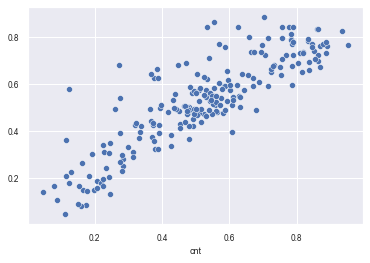

In [159]:
sns.scatterplot(y_test,y_test_pred)
plt.show()

Linear trend observed between ytest and ytest predicted

Model equation

In [160]:
generate_model_equation(lr_model)

Model equation =  0.0766 +(0.5704) * temp -(0.0899) * windspeed +(0.0733) * season_2 +(0.1272) * season_4 +(0.2351) * yr_1 +(0.0901) * mnth_9 -(0.082) * holiday_1 -(0.2316) * weathersit_3


###Summarizing the model
1. A unit increase in temperature affects the demand by 0.5704 units
2. A unit increase in yr affects the demand by 0.2351 units
3. A unit increase in windspeed affects the demand negatively by 0.0899 units
4. A unit increase in weather_sit affects the demand negatively by 0.231 units
5. A unit increase in season affects the demand by 0.0733 and 0.1272 units

temperature, weather situation, year are the important predictors for demand.
Windspeed and seasons are secondary predictors.
All the assumptions of linear regression have been validated.